# Sensor Data #

### Setup ###

In [1]:
# Import libraries
import numpy as np
import json as json
import pandas as pd
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import pylab as pl 
from zoneinfo import ZoneInfo
import imp

In [2]:
# Set options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
#this seems to fix the odd scrolling behavior when charts are present
%matplotlib inline 

In [3]:
# Use dark Background
pl.style.use('dark_background')

### Functions ###

In [4]:
imp.load_source('libs', '/home/mauro/sqrpi/lib/libs.py')
import libs as lb

### Load Settings ###

In [5]:
config=json.loads(open('settings.json','r').read())

In [6]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 
df = float(sample_rate)/float(n)

## Debugging ##

Read the arrays from saved files

In [7]:
npydir = 'npyfiles/fieldtests/'
run = '2025_09_10_17_17' # manual simulation of about 1 mt oscillations

In [8]:
freqs    = np.load(f'{npydir}freqs_{run}.npy')
signal   = np.load(f'{npydir}signal_{run}.npy')
amp_spec = np.load(f'{npydir}amp_spec_{run}.npy')
heights  = np.load(f'{npydir}heights_{run}.npy')
print('signal: ', len(signal), 'amp_spec: ', len(amp_spec))

signal:  720 amp_spec:  38


In [9]:
#signal = np.load(f'{npydir}signal_corr.npy')

### Signal analysis ###

In [10]:
w=40
mavg_signal = lb.moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

720 681


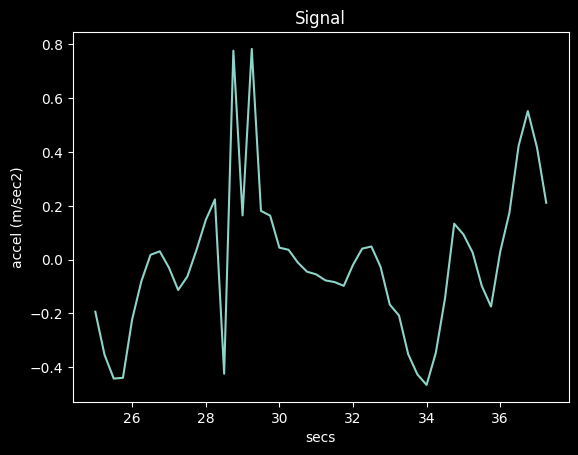

In [11]:
fr=100
#fr = 0
to=150 
#to = ls
pl.title('Signal')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
# moving average
#pl.plot([float(i)/float(sample_rate) for i in range(int(w/2)-1, ls-int(w/2) )],mavg_signal)
# raw signal
pl.plot([float(i)/float(sample_rate) for i in range(fr,to)],signal[fr:to] )
pl.show( )

In [12]:
# subtract moving average
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

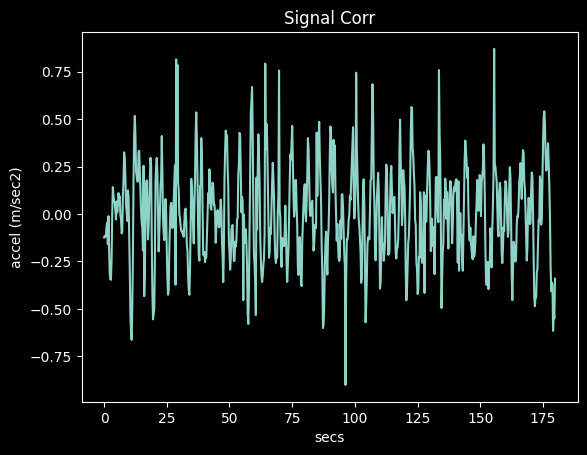

In [13]:
pl.title('Signal Corr')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal_corr[0:ls])
pl.show()

In [14]:
np.save(f'{npydir}signal_corr', signal_corr)

### Acceleration -> Perceived Wave Period ###

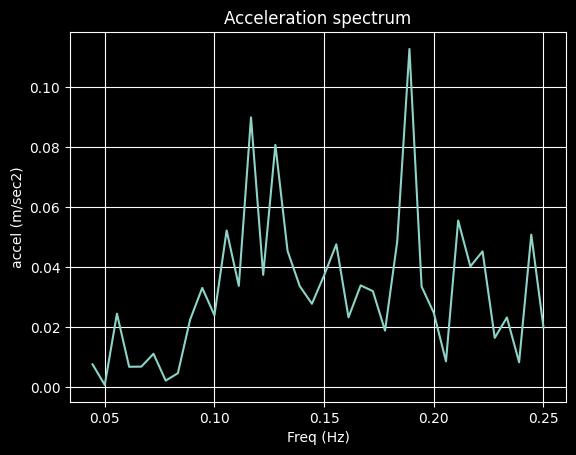

In [15]:
pl.title('Acceleration spectrum')
pl.xlabel('Freq (Hz)')
pl.ylabel('accel (m/sec2)')
pl.plot(freqs, amp_spec)
pl.grid(True)
pl.show()

Identify perceived period using mobile average

In [16]:
w=4
mavg = lb.moving_average(amp_spec, w)
max_index = np.argmax(mavg)+int(w/2)
print('len amp_spec', len(amp_spec), 'len mavg' , len(mavg), 'max index', max_index)

len amp_spec 38 len mavg 35 max index 15


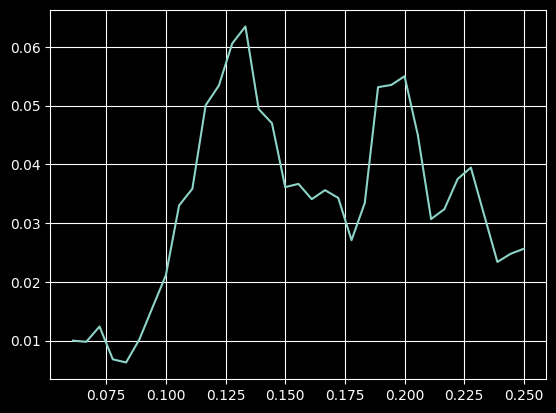

In [17]:
mavg = pl.plot(freqs[3:], mavg)
pl.grid(True)

Perceived period

In [18]:
pw_freq = freqs[max_index]
pw_per = 1/pw_freq
print('Perceived period', round(pw_per,3))

Perceived period 7.826


### Heave ###

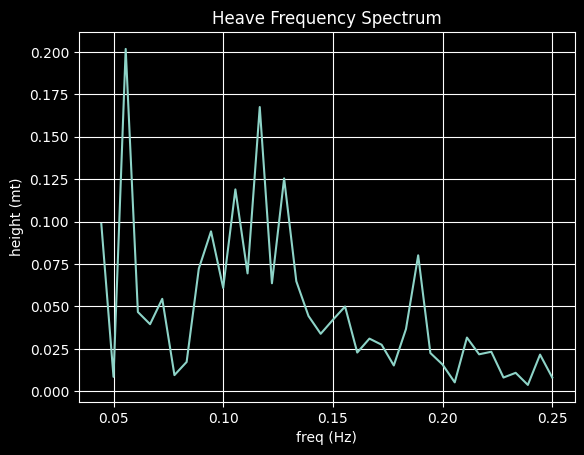

In [19]:
pl.title('Heave Frequency Spectrum')
pl.xlabel('freq (Hz)')
pl.ylabel('height (mt)')
pl.plot(freqs, heights)
pl.grid(True)
pl.show()

### Power Spectral Density -> Dominant Wave Period ###

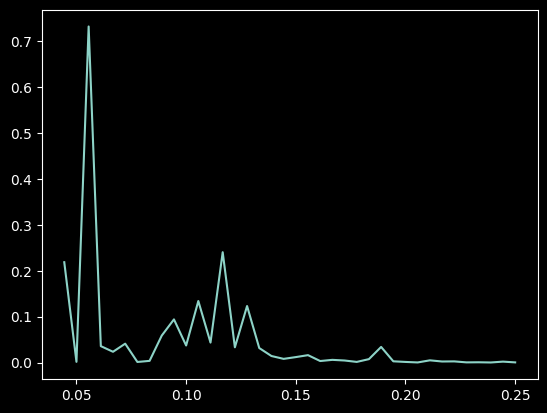

In [20]:
psd = (heights**2)/freqs
pl.plot(freqs, psd )

Dominant Period using PSD

In [21]:
max_index = np.argmax(psd)
print('max_index', max_index, "Dominant period", 1/freqs[max_index])

max_index 2 Dominant period 18.0


### PSD -> Significant Wave Height ###

In [22]:
m0  = sum(psd*df)
sig_wave_height = 4 * math.sqrt(m0) 
print("significant wave height", sig_wave_height)

significant wave height 0.4189471626882647


### PSD -> Average wave period ###

In [23]:
f2=freqs**2

In [24]:
m0

0.01096979532028421

In [25]:
m2=sum(np.multiply(psd,f2)*df)
m2

9.412836126970219e-05

In [26]:
m0/m2

116.54080844829433

In [27]:
math.sqrt(m0/m2)

10.795406821805944

### Amplitude Spectral Density ###

In [28]:
asd = np.sqrt(psd)

In [29]:
m0  = sum(asd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

0.7200589951802459

#### calculate SWH from time series ####

this makes no sense as it is calculated on acceleration, not displacement

In [30]:
m0 = np.var(signal)

In [31]:
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

1.0205137876062702

### Get nearby fix ###

In [32]:
Log_filename    = "log_nmea.csv"

In [33]:
file = open(Log_filename, encoding='utf-8')

In [34]:
f=open(Log_filename, 'r')

In [35]:
lines = f.readlines()

In [36]:
last_rec = lines[-1].strip()
last_rec

'1757548981.55,37.491,-122.29,7.513,258,276,276,303,20.08,330,332.46,96.76,0'

In [37]:
parts = last_rec.split(',')

In [38]:
float(parts[0])

1757548981.55

In [39]:
float(parts[1])

37.491

In [40]:
float(parts[2])

-122.29

In [41]:
import importlib

In [57]:
lb.nearest_fix(1757548781.55)